# Variational Inference with Bensemble

In this notebook, we will demonstrate how to use **bensemble** to train a Bayesian Neural Network using **Variational Inference**.

We will fit a regression model on synthetic data and visualize the uncertainty estimation capabilities of the library.

### Key Concepts:
- **BayesianLinear**: Drop-in replacement for `nn.Linear`.

- **VariationalLoss**: Handles ELBO (Evidence Lower Bound) or Rényi divergence.

- **GaussianLikelihood**: Learns the aleatoric uncertainty (data noise).

In [4]:
# 🛠 Setup: Import library from parent folder
# This allows you to run the notebook without installing the package via pip
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Bensemble imports
from bensemble.layers import BayesianLinear
from bensemble.losses import VariationalLoss, GaussianLikelihood
from bensemble.utils import get_total_kl, predict_with_uncertainty

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Generate Synthetic Data

We create a simple 1D regression task: $y = x^3 + \epsilon$.
Notice that we train on range `[-2, 2]`, but later we will test on `[-4, 4]` to see how the model behaves on out-of-distribution data.

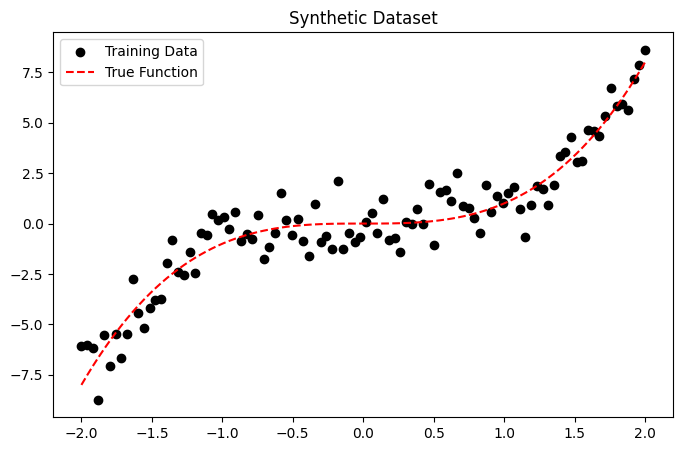

In [ ]:
def true_function(x):
    return x**3

# Generate Training Data 
x_train = torch.linspace(-2, 2, 100).reshape(-1, 1)
y_train = true_function(x_train) + torch.randn_like(x_train) # Add noise

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, c='k', label='Training Data')
plt.plot(x_train, true_function(x_train), 'r--', label='True Function')
plt.legend()
plt.title("Synthetic Dataset")
plt.show()

## 2. Define the Bayesian Model

We use `BayesianLinear` layers instead of standard `nn.Linear`. These layers use the **Local Reparameterization Trick** to sample weights during training.

In [30]:
model = nn.Sequential(
    BayesianLinear(1, 100, prior_sigma=1),
    nn.ReLU(),
    BayesianLinear(100, 1, prior_sigma=1),
)

print(model)

Sequential(
  (0): BayesianLinear()
  (1): ReLU()
  (2): BayesianLinear()
)


## 3. Setup Objectives

We use **GaussianLikelihood** to model the noise in the data  and **VariationalLoss** to minimize the ELBO.

> **Tip:** Change `alpha=0.5` in `VariationalLoss` to use **Rényi Divergence** instead of ELBO.

In [ ]:
likelihood = GaussianLikelihood(init_log_sigma=-2.0)

# Alpha = 1.0 -> Standard ELBO
# Alpha != 1.0 -> Rényi Bound
loss_fn = VariationalLoss(likelihood, alpha=1.0, kl_weight=0.5)

# Optimize both model parameters and likelihood noise
optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.01)

## 4. Training Loop

Standard PyTorch training loop. We just need to calculate KL divergence using `get_total_kl`.

In [32]:
epochs = 5000
model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    preds = model(x_train)
    kl = get_total_kl(model)
    
    loss = loss_fn(preds, y_train, kl)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Sigma: {likelihood.sigma:.4f}")

Epoch 500/5000 | Loss: 640.5886 | Sigma: 0.3781
Epoch 1000/5000 | Loss: 405.2461 | Sigma: 0.5176
Epoch 1500/5000 | Loss: 332.8788 | Sigma: 0.6381
Epoch 2000/5000 | Loss: 264.4446 | Sigma: 0.7484
Epoch 2500/5000 | Loss: 243.6118 | Sigma: 0.8467
Epoch 3000/5000 | Loss: 206.4996 | Sigma: 0.9285
Epoch 3500/5000 | Loss: 189.8750 | Sigma: 0.9935
Epoch 4000/5000 | Loss: 188.0232 | Sigma: 1.0468
Epoch 4500/5000 | Loss: 174.0175 | Sigma: 1.0891
Epoch 5000/5000 | Loss: 176.0767 | Sigma: 1.1260


## 5. Visualization & Uncertainty

Now we predict on a wider range `[-4, 4]` using Monte Carlo sampling via `predict_with_uncertainty`.

Notice how the uncertainty (blue area) expands where we have no training data.

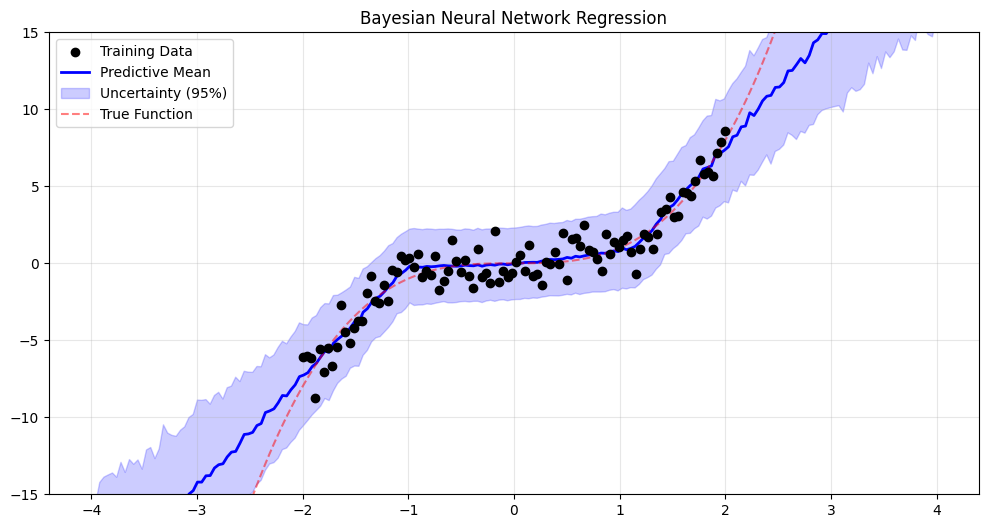

In [ ]:
# Test on a wider range to see out-of-distribution behavior
x_test = torch.linspace(-4, 4, 200).reshape(-1, 1)

# 1. Get Model Uncertainty (Mean & Std from 100 MC samples)
mean, std_model = predict_with_uncertainty(model, x_test, num_samples=100)

# 2. Add Data Noise (Aleatoric Uncertainty)
# Total Variance = Model Variance + Data Variance
std_total = torch.sqrt(std_model**2 + likelihood.sigma**2)

# Prepare for plotting
x = x_test.flatten().numpy()
y_mean = mean.flatten().numpy()
y_std = std_total.flatten().numpy()

# --- PLOTTING ---
plt.figure(figsize=(12, 6))

# Training Data
plt.scatter(x_train, y_train, c='black', zorder=5, label='Training Data')

# Mean Prediction
plt.plot(x, y_mean, c='blue', linewidth=2, label='Predictive Mean')

# Uncertainty Bands (2 Sigma = 95% confidence)
plt.fill_between(x, y_mean - 2*y_std, y_mean + 2*y_std, 
                 color='blue', alpha=0.2, label='Uncertainty (95%)')

# True Function
plt.plot(x, true_function(torch.tensor(x)), 'r--', alpha=0.5, label='True Function')

plt.ylim(-15, 15)
plt.title("Bayesian Neural Network Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()